Kimonet demo
------------

Install necessary modules

In [ ]:
!pip install kimonet

Load general modules

In [64]:
import numpy as np

Define states

In [65]:
from kimonet.system.state import ground_state as gs
from kimonet.system.state import State

s1 = State(label='s1', energy=20.0, multiplicity=1)

Define states pair properties

In [66]:
from kimonet.core.processes.transitions import Transition

transitions = [Transition(s1, gs,
                          tdm=[0.1, 0.0],  # a.u.
                          reorganization_energy=0.08)] # eV

Define system

In [67]:
from kimonet.system.molecule import Molecule
from kimonet.system.generators import crystal_system

# define system as a crystal
molecule_type_1 = Molecule(site_energy=0.0)
molecule_type_2 = Molecule(site_energy=0.0)

system = crystal_system(molecules=[molecule_type_1, molecule_type_2],
                        scaled_site_coordinates=[[0.0, 0.0],
                                                 [0.0, 0.5]],
                        unitcell=[[5.0, 1.0],
                                  [1.0, 5.0]],
                        dimensions=[2, 2],  # supercell size
                        orientations=[[0.0, 0.0, np.pi/2],
                                      [0.0, 0.0, 0.0]])

Place excitons in the initial system

In [68]:
system.add_excitation_index(s1, 0)
system.add_excitation_index(s1, 1)

Define the processes available in the system

In [69]:
from kimonet.system.vibrations import MarcusModel
from kimonet.core.processes.couplings import forster_coupling
from kimonet.core.processes.decays import einstein_radiative_decay
from kimonet.core.processes.types import GoldenRule, DecayRate


system.process_scheme = [GoldenRule(initial_states=(s1, gs), final_states=(gs, s1),
                                    electronic_coupling_function=forster_coupling,
                                    description='Forster coupling',
                                    arguments={'ref_index': 1,
                                               'transitions': transitions},
                                    vibrations=MarcusModel(transitions=transitions) # eV
                                    ),
                        DecayRate(initial_state=s1, final_state=gs,
                                  decay_rate_function=einstein_radiative_decay,
                                  arguments={'transitions': transitions},
                                  description='custom decay rate')
                        ]

Set additional paramters of the simulation

In [70]:
system.cutoff_radius = 8  # interaction cutoff radius in Angstrom


Show system unit cell

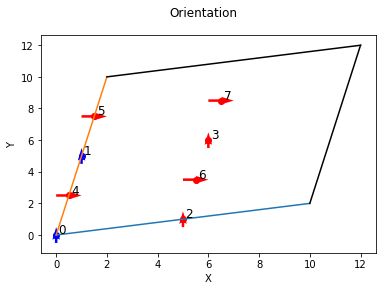

In [71]:
from kimonet.analysis import visualize_system

visualize_system(system)

List processes for initial system

In [72]:
from kimonet import system_test_info

system_test_info(system)


********************************************************************************
 CENTER 0
********************************************************************************
Description: custom decay rate
Donor: 0 / Acceptor: 0
Rate constant: 0.08505 ns-1
--------------------------------------------------------------------------------
Description: Forster coupling
Donor: 0 / Acceptor: 2
Distance: 5.099 angs
Cell_increment: [1 0] 
Electronic coupling: 0.0002381 eV
Spectral overlap:    0.9335 eV-1
Rate constant: 0.5051 ns-1
--------------------------------------------------------------------------------
Description: Forster coupling
Donor: 0 / Acceptor: 2
Distance: 5.099 angs
Cell_increment: [0 0] 
Electronic coupling: 0.0002381 eV
Spectral overlap:    0.9335 eV-1
Rate constant: 0.5051 ns-1
--------------------------------------------------------------------------------
Description: Forster coupling
Donor: 0 / Acceptor: 3
Distance: 5.657 angs
Cell_increment: [1 0] 
Electronic coupling: 5.5

Run Kinetic Montecarlo algorithm

In [73]:
from kimonet import calculate_kmc

trajectories = calculate_kmc(system,
                             num_trajectories=5,    # number of trajectories that will be simulated
                             max_steps=10,        # maximum number of steps for trajectory allowed
                             silent=True)

/Users/abel/PycharmProjects/kimonet/kimonet/__init__.py:34: UserWarning: Maximum number of steps reached!!
  warn('Maximum number of steps reached!!')


Print the global results

In [74]:
from kimonet.analysis import TrajectoryAnalysis

analysis = TrajectoryAnalysis(trajectories)

print('diffusion coefficient: {:9.5e} Angs^2/ns'.format(analysis.diffusion_coefficient()))
print('lifetime:              {:9.5e} ns'.format(analysis.lifetime()))
print('diffusion length:      {:9.5e} Angs'.format(analysis.diffusion_length()))
print('diffusion tensor (angs^2/ns)')



diffusion coefficient: 6.54184e+01 Angs^2/ns
lifetime:              7.77718e-01 ns
diffusion length:      1.17813e+01 Angs
diffusion tensor (angs^2/ns)


/Users/abel/PycharmProjects/kimonet/kimonet/analysis/trajectory_graph.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._coordinates_dict[state] = np.array([np.array(ar).T.tolist() for ar in self._vector_list_global()[0]])


Print results per state

In [75]:
for state in analysis.get_states():
    print('\nState: {}\n--------------------------------'.format(state))
    print('diffusion coefficient: {:9.5e} Angs^2/ns'.format(analysis.diffusion_coefficient(state)))
    print('lifetime:              {:9.5e} ns'.format(analysis.lifetime(state)))
    print('diffusion length:      {:9.5e} Angs'.format(analysis.diffusion_length(state)))
    print('diffusion tensor (angs^2/ns)')


State: s1
--------------------------------
diffusion coefficient: 6.54184e+01 Angs^2/ns
lifetime:              7.60219e-01 ns
diffusion length:      1.17813e+01 Angs
diffusion tensor (angs^2/ns)


Plot diffusion coefficient and length tensors

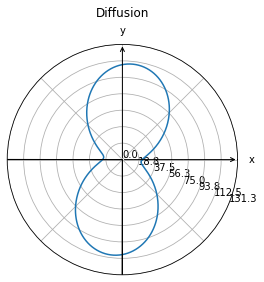

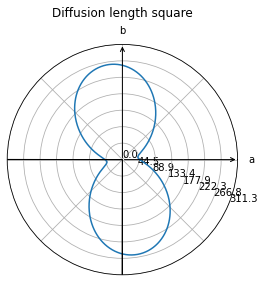

In [76]:
from kimonet.analysis import plot_polar_plot

plot_polar_plot(analysis.diffusion_coeff_tensor('s1'), 
                title='Diffusion', 
                plane=[0, 1])

plot_polar_plot(analysis.diffusion_length_square_tensor('s1', unit_cell=[[5.0, 1.0],
                                                                         [1.0, 5.0]]),
                title='Diffusion length square', 
                crystal_labels=True, 
                plane=[0, 1])


Plot exciton density distances

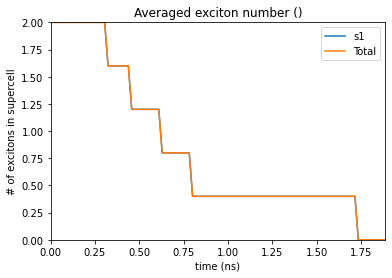

In [77]:
for state in analysis.states:
    analysis.plot_exciton_density(state)
plt = analysis.plot_exciton_density()
plt.show()

Plot exciton trajectories

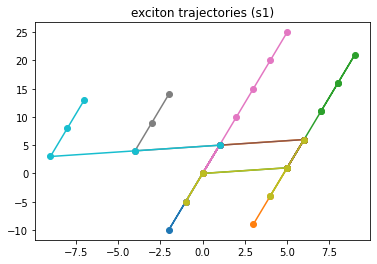

In [78]:
analysis.plot_2d('s1').show()